In [1]:
import os
import numpy as np
import pandas as pd
from math import sqrt
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from scipy.stats import uniform, randint
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, GridSearchCV
import xgboost as xgb
from xgboost import plot_tree
import matplotlib.pyplot as plt

from IPython.display import display, HTML
display(HTML("<style>.container { width:55% !important; }</style>"))

# Data

In [19]:
dataset_df = pd.read_json("./data/all_ads.json")
dataset_df = dataset_df.drop(["id", "category"], axis=1)
# dataset_df.head(5)

In [3]:
df_skoda = dataset_df[dataset_df.manufacturer_cb == "Škoda"]
df_skoda = df_skoda.drop("manufacturer_cb", axis=1)
df_skoda.head()

,fuel_cb,gearbox_cb,locality,model_cb,price,tachometer,vehicle_age
106,Benzín,Manuální,Jihočeský kraj,Fabia,440900,0,0
107,Benzín,Manuální,Jihočeský kraj,Fabia,440900,0,0
108,Benzín,Manuální,Jihočeský kraj,Fabia,440900,0,0
109,Benzín,Manuální,Jihočeský kraj,Fabia,505600,0,0
110,Benzín,Manuální,Jihočeský kraj,Fabia,404100,0,0


In [4]:
score_df = df_skoda.copy()
onehot_columns = ['fuel_cb', 'gearbox_cb', 'locality', 'model_cb']
onehot_df = score_df[onehot_columns]
onehot_df = pd.get_dummies(onehot_df, columns=onehot_columns, prefix_sep='-')
score_onehot_drop = score_df.drop(onehot_columns, axis=1)
score_onehot = pd.concat([score_onehot_drop, onehot_df], axis=1)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(score_onehot.drop(['price'], axis=1), score_onehot.price, test_size=0.20, random_state=42)

# Model & Training

In [44]:
# params = {
#     'learning_rate': (0.1,),
#     'subsample'    : (0.2,),
#     'n_estimators' : (500,),
#     'max_depth'    : (28,),
# }

# xgb_model = GradientBoostingRegressor()
# xgb_search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=42, verbose=1, n_jobs=2, return_train_score=True)

params = {
    'max_depth': [10],
    'n_estimators': [50]
}
xgb_model = xgb.XGBRegressor()
xgb_search = GridSearchCV(xgb_model, params, verbose=1, n_jobs=2)

In [45]:
%%time
xgb_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: user 4.33 s, sys: 809 ms, total: 5.14 s
Wall time: 2.85 s


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None, ...),
             n_jobs=2, param_grid={'max_depth': [10], 'n_estimators': [50]},
             verbose=1)

In [46]:
y_pred = xgb_search.predict(X_test)
rms = sqrt(mean_squared_error(y_test, y_pred))
print ('RMSE:', rms)

RMSE: 64982.21148750965


# Show me the results!

In [47]:
def undummify(df, prefix_sep="-"):
    cols2collapse = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    series_list = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df

In [48]:
pd.options.display.float_format = '{:.0f}'.format

df_results = pd.DataFrame({"predicted": y_pred, "real": y_test})
df_results["diff"] = df_results.real - df_results.predicted
df_results["diff_abs"] = abs(df_results.real - df_results.predicted)
df_results["diff_abs_round"] = round(abs(df_results.real - df_results.predicted), -3)
df_results.drop(["diff", "diff_abs"], axis=1, inplace=True)
df_results = df_results.merge(undummify(X_test), left_index=True, right_index=True).head(2000)
df_results.head(20)

,predicted,real,diff_abs_round,tachometer,vehicle_age,fuel_cb,gearbox_cb,locality,model_cb
66943,561991,616000,54000,24715,2,Benzín,Automatická,Hlavní město Praha,Kamiq
65224,704999,679900,25000,23328,1,Benzín,Manuální,Středočeský kraj,Karoq
50177,470645,485000,14000,169558,6,Nafta,Automatická,Hlavní město Praha,Superb
18394,517730,438000,80000,44022,2,Benzín,Automatická,Hlavní město Praha,Octavia
24374,693848,749999,56000,129000,4,Nafta,Automatická,Karlovarský kraj,Kodiaq
36201,1119339,1199000,80000,11290,3,Nafta,Automatická,Středočeský kraj,Kodiaq
12967,272562,340000,67000,85545,6,Benzín,Manuální,Hlavní město Praha,Rapid
42333,648450,659000,11000,7174,0,Benzín,Manuální,Hlavní město Praha,Kamiq
71997,182175,176000,6000,184662,8,Nafta,Manuální,Hlavní město Praha,Rapid
7185,377823,379000,1000,93995,5,Nafta,Manuální,Středočeský kraj,Octavia


In [49]:
# worst
df_results.sort_values(by='diff_abs_round', ascending=False).head(20)

,predicted,real,diff_abs_round,tachometer,vehicle_age,fuel_cb,gearbox_cb,locality,model_cb
6461,981376,1455500,474000,16325,1,Nafta,Automatická,Plzeňský kraj,Superb
2151,720997,1159900,439000,11965,2,Nafta,Automatická,Plzeňský kraj,Karoq
65396,731644,344800,387000,133428,0,Nafta,Manuální,Moravskoslezský kraj,Octavia
48180,1004172,1389000,385000,42556,1,Nafta,Automatická,Jihomoravský kraj,Kodiaq
18115,1039034,1350000,311000,26361,2,Nafta,Automatická,Hlavní město Praha,Kodiaq
18242,690357,999000,309000,118360,3,Nafta,Automatická,Jihomoravský kraj,Kodiaq
22718,1279773,1586000,306000,0,0,Benzín,Automatická,Hlavní město Praha,Superb
54984,1075448,799000,276000,26350,1,Nafta,Automatická,Hlavní město Praha,Kodiaq
36178,834158,1109100,275000,63520,3,Nafta,Automatická,Jihočeský kraj,Kodiaq
13739,861848,1133800,272000,12000,1,Benzín,Automatická,Hlavní město Praha,Octavia


In [50]:
# best
df_results.sort_values(by='diff_abs_round', ascending=True).head(30)

,predicted,real,diff_abs_round,tachometer,vehicle_age,fuel_cb,gearbox_cb,locality,model_cb
68257,319082,319000,0,46505,4,Benzín,Manuální,Jihočeský kraj,Rapid
33300,119666,119999,0,113000,14,Benzín,Manuální,Středočeský kraj,Fabia
64436,418278,417800,0,0,0,Benzín,Manuální,Ústecký kraj,Fabia
77089,43520,44000,0,185557,21,Benzín,Manuální,Ústecký kraj,Fabia
76277,49504,50000,0,84577,20,Benzín,Manuální,Hlavní město Praha,Fabia
51406,116442,116000,0,149100,13,Benzín,Manuální,Moravskoslezský kraj,Fabia
9720,659012,659000,0,115128,3,Nafta,Automatická,Ústecký kraj,Superb
37943,299110,299000,0,87968,4,Benzín,Manuální,Moravskoslezský kraj,Rapid
56691,79800,79900,0,268001,17,Nafta,Manuální,Hlavní město Praha,Octavia
54445,238907,239000,0,116510,5,Benzín,Manuální,Hlavní město Praha,Fabia


<AxesSubplot: xlabel='percent_error'>

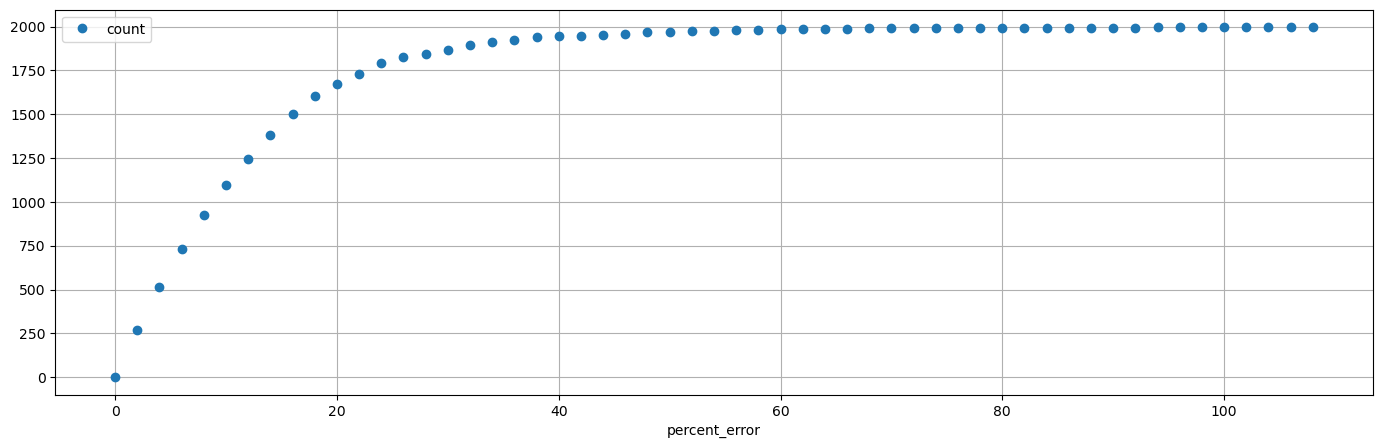

In [69]:
percent_error_counts = []
for percent_error in range(0, 110, 2):
    count = df_results[(df_results.diff_abs_round / df_results.real) * 100 < percent_error].real.count()
    percent_error_counts.append({
        "percent_error": percent_error,
        "count": count,
    })

df_percent_error = pd.DataFrame(percent_error_counts)

df_percent_error.plot(x='percent_error', y='count', style='o', grid=True, figsize=(17,5))

In [51]:
df_results.real[df_results.diff_abs_round <= 20000].count()

761

In [52]:
df_results.real.count()

2000